In [10]:
# Clone repository with real-time implementation
!git clone -b Youxin https://github.com/SmashCodeJJ/CIS5810_FinalProject.git sber-swap
!cd /content/sber-swap  # ✅ Use %cd, not !cd

# Install dependencies
%pip install -q -r requirements.txt

# Download models (if needed)
import os
if not os.path.exists('weights/G_unet_2blocks.pth'):
    print("Downloading models...")
    !bash download_models.sh 2>/dev/null || echo "Note: Models may need manual download"

print("\n" + "="*50)
print("✅ Installation complete!")
print("⚠️  IMPORTANT: Go to Runtime → Restart runtime")
print("="*50)

fatal: destination path 'sber-swap' already exists and is not an empty directory.

✅ Installation complete!
⚠️  IMPORTANT: Go to Runtime → Restart runtime


In [ ]:
%cd /content/sber-swap

import torch
import numpy as np
import cv2

print("="*50)
print("✅ Environment Check")
print("="*50)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*50)

/content/sber-swap
✅ Environment Check
PyTorch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4


In [ ]:
!python inference.py \
  --image_to_image True \
  --target_image examples/images/beckham.jpg \
  --source_paths examples/images/mark.jpg \
  --out_image_name examples/results/ghost_result.png

Traceback (most recent call last):
  File "/content/sber-swap/inference.py", line 8, in <module>
    from utils.inference.image_processing import crop_face, get_final_image
  File "/content/sber-swap/utils/inference/image_processing.py", line 10, in <module>
    from insightface.utils import face_align
ModuleNotFoundError: No module named 'insightface'


In [ ]:
from IPython.display import Image as IPImage, display, clear_output
import matplotlib.pyplot as plt
import cv2
import filecmp
import os

# Use correct path
result_path = '/content/sber-swap/examples/results/ghost_result.png'
target_path = '/content/sber-swap/examples/images/beckham.jpg'
source_path = '/content/sber-swap/examples/images/mark.jpg'

if os.path.exists(result_path):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Source
    if os.path.exists(source_path):
        source = cv2.imread(source_path)
        axes[0].imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Source (Mark)', fontsize=14)
        axes[0].axis('off')

    # Target
    if os.path.exists(target_path):
        target = cv2.imread(target_path)
        axes[1].imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Target (Beckham)', fontsize=14)
        axes[1].axis('off')

    # Result
    result = cv2.imread(result_path)
    axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[2].set_title('RESULT - Face Swapped', fontsize=14, color='green', weight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Check if same
    if os.path.exists(target_path):
        same = filecmp.cmp(target_path, result_path)
        if same:
            print("❌ RESULT IS IDENTICAL - Face swap didn't work")
        else:
            print("✅ RESULT IS DIFFERENT - Face swap worked!")

Upload SOURCE face image (the face to swap onto the webcam):


Saving mark.jpg to mark.jpg
✅ Source image saved to: /content/sber-swap/examples/my_images/mark.jpg


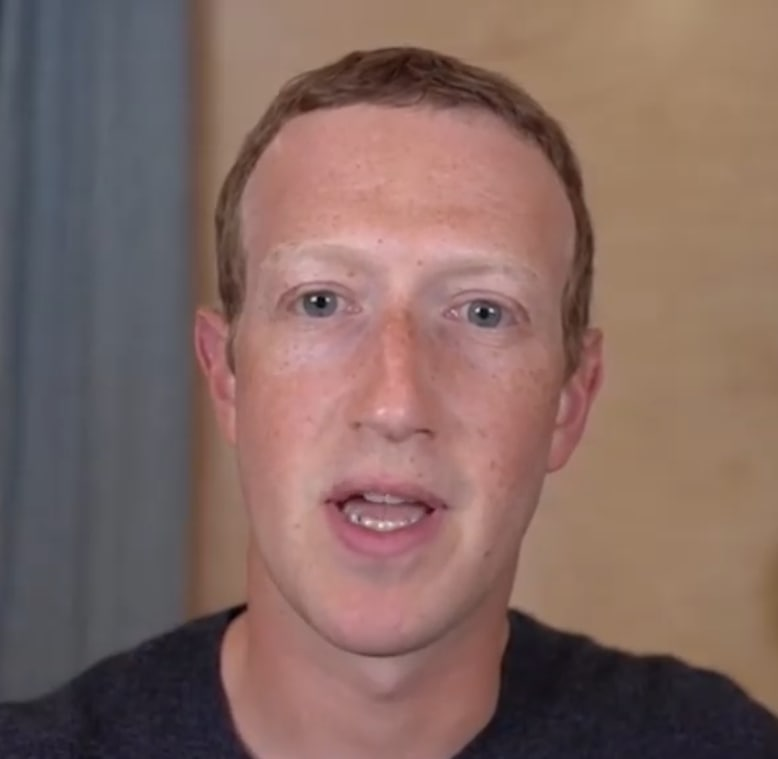

In [ ]:
from google.colab import files
from IPython.display import Image as IPImage, display, clear_output
import os

# Create directory for uploads
!mkdir -p /content/sber-swap/examples/my_images

# Upload source face image
print("Upload SOURCE face image (the face to swap onto the webcam):")
uploaded = files.upload()

source_path = None
for filename in uploaded.keys():
    source_path = f"/content/sber-swap/examples/my_images/{filename}"
    !mv "{filename}" "{source_path}"
    print(f"✅ Source image saved to: {source_path}")
    display(Image(source_path))
    break

if source_path is None:
    print("⚠️  Using default source image")
    source_path = "/content/sber-swap/examples/images/mark.jpg"


In [19]:
import base64
import io
from PIL import Image
import numpy as np
import cv2
from IPython.display import display, HTML, Javascript
from google.colab.output import eval_js

def take_photo():
    """Capture photo from webcam using JavaScript"""
    # Use eval_js directly with JavaScript string
    js_code = '''
    async function takePhoto() {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        video.play();

        await new Promise(resolve => {
            video.onloadedmetadata = () => {
                video.setAttribute('width', video.videoWidth);
                video.setAttribute('height', video.videoHeight);
                resolve();
            }
        });

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        const ctx = canvas.getContext('2d');
        ctx.drawImage(video, 0, 0);

        video.srcObject.getTracks().forEach(track => track.stop());
        return canvas.toDataURL('image/jpeg', 0.95);
    }
    '''

    # Execute JavaScript and get result
    data = eval_js(js_code + 'takePhoto()')

    # Decode base64 image
    image_bytes = base64.b64decode(data.split(',')[1])
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to OpenCV format
    frame = np.array(image)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    return frame

print("✅ Webcam capture function ready!")


✅ Webcam capture function ready!


In [20]:
import time
from collections import deque

class PerfMonitor:
    def __init__(self, window=30):
        self.window = window
        self.frame_start_time = None
        self.processing_ms = deque(maxlen=window)
        self.det_ms = deque(maxlen=window)
        self.gen_ms = deque(maxlen=window)

    # --- per-frame lifecycle ---
    def start_frame(self):
        self.frame_start_time = time.time()

    def end_frame(self):
        # if user didn't call record_processing_time, compute it here
        if self.frame_start_time is not None:
            elapsed_ms = (time.time() - self.frame_start_time) * 1000.0
            self.processing_ms.append(elapsed_ms)
            self.frame_start_time = None

    # --- components you record during the loop ---
    def record_detection_time(self, ms):
        if ms is None: return
        self.det_ms.append(float(ms))

    def record_generator_time(self, ms):
        if ms is None: return
        self.gen_ms.append(float(ms))

    def record_processing_time(self, ms):
        if ms is None: return
        self.processing_ms.append(float(ms))

    # --- stats for overlay/printing ---
    def get_stats(self):
        def avg(q):
            return float(sum(q)/len(q)) if len(q) else 0.0
        avg_proc = avg(self.processing_ms)
        fps = (1000.0 / avg_proc) if avg_proc > 0 else 0.0
        return {
            "fps": fps,
            "avg_latency_ms": avg_proc,
            "avg_detection_ms": avg(self.det_ms),
            "avg_generator_ms": avg(self.gen_ms),
        }

# instantiate before your while-loop
monitor = PerfMonitor(window=60)


In [ ]:
import cv2
import numpy as np

class ImprovedFaceTracker:
    """
    Improved face tracker using InsightFace for better detection.
    Falls back to Haar cascade if InsightFace is not available.
    """
    def __init__(self, app=None, min_size=80):
        self.app = app  # InsightFace detector (will be set in cell 9)
        self.min_size = min_size
        
        # Fallback: Haar cascade (always available)
        self.cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        
        # Tracker
        self.tracker = None
        self.bbox = None
        self.frame_count = 0
        self.detect_interval = 5  # Run full detection every N frames

    def _new_tracker(self):
        # prefer MOSSE (fast); fall back to KCF; handle legacy API names
        tracker = None
        for ctor in [
            lambda: cv2.legacy.TrackerMOSSE_create(),
            lambda: cv2.legacy.TrackerKCF_create(),
            lambda: cv2.TrackerMOSSE_create(),
            lambda: cv2.TrackerKCF_create(),
        ]:
            try:
                tracker = ctor()
                break
            except Exception:
                continue
        return tracker

    def _detect_face_insightface(self, frame):
        """Use InsightFace for detection (more accurate)"""
        if self.app is None:
            return None
        try:
            # Get keypoints (faster than full crop)
            kps = self.app.get(frame, 224)
            if not kps or len(kps) == 0:
                return None
            
            # Get bounding box from keypoints
            first_kp = kps[0]
            if first_kp is None:
                return None
            
            # Calculate bounding box from keypoints
            x_coords = [kp[0] for kp in first_kp]
            y_coords = [kp[1] for kp in first_kp]
            x = int(min(x_coords))
            y = int(min(y_coords))
            w = int(max(x_coords) - x)
            h = int(max(y_coords) - y)
            
            # Expand bbox slightly
            padding = 20
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(frame.shape[1] - x, w + 2 * padding)
            h = min(frame.shape[0] - y, h + 2 * padding)
            
            return (x, y, w, h)
        except Exception as e:
            print(f"InsightFace detection error: {e}")
            return None

    def _detect_face_haar(self, frame):
        """Fallback: Use Haar cascade with relaxed parameters for better detection"""
        if frame.ndim == 3 and frame.shape[2] == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray = frame
        # More relaxed parameters: lower scaleFactor and minNeighbors for better detection
        faces = self.cascade.detectMultiScale(
            gray, 
            scaleFactor=1.1,  # Smaller = more thorough search (slower but better)
            minNeighbors=3,  # Lower = more sensitive (may catch partial faces)
            minSize=(self.min_size, self.min_size)
        )
        if len(faces) == 0:
            return None
        # pick the largest face
        x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
        
        # Add padding around the detected face for better robustness
        pad = int(0.1 * max(w, h))  # 10% padding
        H, W = frame.shape[:2]
        x = max(0, x - pad)
        y = max(0, y - pad)
        w = min(W - x, w + 2 * pad)
        h = min(H - y, h + 2 * pad)
        
        return (int(x), int(y), int(w), int(h))

    def update(self, frame):
        self.frame_count += 1
        
        # Try tracking first if we have an active tracker
        if self.tracker is not None and self.bbox is not None:
            ok, new_box = self.tracker.update(frame)
            if ok:
                x, y, w, h = map(int, new_box)
                # Validate bbox
                H, W = frame.shape[:2]
                x = max(0, min(x, W - 1))
                y = max(0, min(y, H - 1))
                w = max(1, min(w, W - x))
                h = max(1, min(h, H - y))
                self.bbox = (x, y, w, h)
                
                # Still do periodic detection for accuracy
                if self.frame_count % self.detect_interval == 0:
                    box = self._detect_face_insightface(frame)
                    if box is None:
                        box = self._detect_face_haar(frame)
                    if box is not None:
                        self.tracker = self._new_tracker()
                        if self.tracker is not None:
                            self.tracker.init(frame, tuple(map(float, box)))
                        self.bbox = box
                
                return self.bbox
            # tracker lost → reset and fall back to detection
            self.tracker = None
            self.bbox = None

        # (re)detect - prefer InsightFace, fallback to Haar
        box = self._detect_face_insightface(frame)
        if box is None:
            box = self._detect_face_haar(frame)
        if box is None:
            return None

        # (re)init tracker
        self.tracker = self._new_tracker()
        if self.tracker is not None:
            self.tracker.init(frame, tuple(map(float, box)))
        self.bbox = box
        return self.bbox
    
    def reset(self):
        """Reset tracker state"""
        self.tracker = None
        self.bbox = None
        self.frame_count = 0

# Create the tracker instance - app will be set in cell 9
tracker = ImprovedFaceTracker()

In [ ]:
# NOTE: The real process_single_frame function is imported from utils.inference.realtime_processing
# This cell is kept for reference but the actual function is in cell 9

# The real implementation does:
# 1. Face detection using InsightFace (app.get())
# 2. Face alignment and cropping
# 3. Face embedding extraction
# 4. Face swapping using the generator (G)
# 5. Mask generation and blending
# 6. Returns the swapped frame

print("✅ Using real face swap implementation from utils.inference.realtime_processing")

In [ ]:
# Initialize models and load source face
# 
# ⚠️  IMPORTANT STEPS:
#     1. First run CELL 4 to upload your source face image (e.g., Elon Musk)
#     2. THEN run this cell to load models and the uploaded face
#     3. If you've run this before with errors: Runtime → Restart runtime first
#        (Otherwise the old FP16 model will still be in memory)
#
import sys
import os
sys.path.insert(0, '/content/sber-swap')

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from utils.inference.image_processing import crop_face, normalize_and_torch
from utils.inference.realtime_processing import process_single_frame
import torch.nn.functional as F

print("📦 Loading models... This may take 1-2 minutes...")
print("⚠️  If this is NOT your first time running this cell, RESTART RUNTIME first!")

# ⚙️ Detection parameters (adjust if faces aren't detected)
# Lower det_thresh (e.g., 0.5) = more sensitive, detects more faces (may include false positives)
# Higher det_thresh (e.g., 0.7) = more strict, only detects clear faces (may miss some faces)
DET_THRESHOLD = 0.6  # Try 0.5 if detection is too strict, or 0.7 if too many false positives
DET_SIZE = (640, 640)  # Smaller (320, 320) = faster but less accurate

# Initialize face detection model
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id=0, det_thresh=DET_THRESHOLD, det_size=DET_SIZE)

# Initialize generator model
G = AEI_Net('unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
# Keep in FP32 for stability (FP16 can cause spatial dimension mismatches)
# G = G.half()  # Commented out: FP16 causes tensor size errors in concatenation

# Initialize ArcFace model for embeddings
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc = netArc.cuda()
netArc.eval()

# Initialize landmark detection handler
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# Load source face embedding (compute once, reuse for all frames)
# AUTO-DETECT: Find whatever image you uploaded in my_images directory
my_images_dir = '/content/sber-swap/examples/my_images'
if os.path.exists(my_images_dir):
    # Get all image files in the directory
    uploaded_images = [f for f in os.listdir(my_images_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if uploaded_images:
        # Use the most recently uploaded image
        source_path = os.path.join(my_images_dir, uploaded_images[-1])
        print(f"🎯 Found uploaded image: {uploaded_images[-1]}")
    else:
        print("⚠️  No images found in my_images directory, using default")
        source_path = '/content/sber-swap/examples/images/mark.jpg'
else:
    print("⚠️  my_images directory not found, using default")
    source_path = '/content/sber-swap/examples/images/mark.jpg'

print(f"📸 Loading source face: {source_path}")
source_img = cv2.imread(source_path)
if source_img is None:
    raise ValueError(f"Could not read source image: {source_path}")

face_crop = crop_face(source_img, app, crop_size=224)
if not face_crop or len(face_crop) == 0:
    raise ValueError(f"No face detected in source image: {source_path}")

# Get embedding (compute once, reuse for all frames)
source_normalized = normalize_and_torch(face_crop[0])
source_embed = netArc(F.interpolate(source_normalized, scale_factor=0.5, mode='bilinear', align_corners=True))

print("✅ Models loaded successfully!")
print("✅ Source face loaded and embedded!")

# Verify generator is in FP32 mode
g_dtype = next(G.parameters()).dtype
print(f"\n🔍 Generator dtype: {g_dtype}")
if g_dtype == torch.float16:
    print("⚠️  WARNING: Generator is in FP16! This will cause errors.")
    print("   Please RESTART RUNTIME and re-run this cell!")
elif g_dtype == torch.float32:
    print("✅ Generator is correctly in FP32 mode")

# Connect tracker to InsightFace detector for better face detection
tracker.app = app

# Args for processing
from types import SimpleNamespace
args = SimpleNamespace(crop_size=224)

print("\n" + "="*60)
print("✅ Setup Complete!")
print("="*60)
print("Ready to process frames with real face swapping!")
print(f"Detection threshold: {DET_THRESHOLD} (lower = more sensitive)")
print(f"Detection size: {DET_SIZE}")
print("\n💡 TIPS:")
print("   - If faces aren't detected: Lower DET_THRESHOLD to 0.5")
print("   - If too many false positives: Raise DET_THRESHOLD to 0.7")
print("   - Ensure good lighting and face the camera directly")
print("   - Using FP32 (not FP16) for better stability")
print("   - Face crop now includes forehead for complete face swap")
print("="*60)


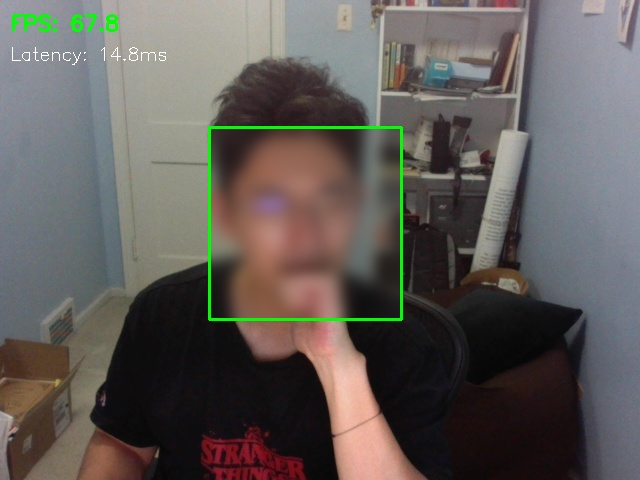

✅ Frame processed! FPS: 67.8 | Latency: 14.8ms | Detection: 0.0ms | Generator: 5.7ms

📸 Click this cell again to capture another frame!


In [ ]:
# Single frame capture (click this cell multiple times for multiple frames)
try:
    # Capture frame from webcam
    frame = take_photo()

    # Start monitoring
    monitor.start_frame()

    # Update tracker
    bbox = tracker.update(frame)

    # Process frame
    det_time = 0
    gen_time = 0
    result = None

    if bbox is not None:
        result, det_time, gen_time = process_single_frame(
            frame=frame,
            source_embed=source_embed,
            netArc=netArc,
            G=G,
            app=app,
            handler=handler,
            bbox=bbox,
            crop_size=args.crop_size,
            half=False  # Use FP32 for stability
        )

    # Record metrics
    monitor.record_detection_time(det_time)
    monitor.record_generator_time(gen_time)
    total_time = (time.time() - monitor.frame_start_time) * 1000 if monitor.frame_start_time else 0
    monitor.record_processing_time(total_time)
    monitor.end_frame()

    # Display result
    if result is not None and bbox is not None:
        # Expand bbox to show actual swap area (includes forehead and mask expansion)
        x, y, w, h = bbox
        
        # Expand by 20% to better represent actual swap area with mask dilation
        expand_factor = 0.20
        x_expanded = int(x - w * expand_factor / 2)
        y_expanded = int(y - h * expand_factor)  # More expansion upward for forehead
        w_expanded = int(w * (1 + expand_factor))
        h_expanded = int(h * (1 + expand_factor * 1.5))
        
        # Clamp to frame boundaries
        x_expanded = max(0, x_expanded)
        y_expanded = max(0, y_expanded)
        w_expanded = min(result.shape[1] - x_expanded, w_expanded)
        h_expanded = min(result.shape[0] - y_expanded, h_expanded)
        
        # Draw expanded bbox (represents actual swap area)
        cv2.rectangle(result, (x_expanded, y_expanded), 
                     (x_expanded + w_expanded, y_expanded + h_expanded), 
                     (0, 255, 0), 2)
        
        # Add label
        cv2.putText(result, "Swap Area (with forehead)", 
                   (x_expanded, y_expanded - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Add text with stats
        stats = monitor.get_stats()
        cv2.putText(result, f"Face Swapped! FPS: {stats['fps']:.1f}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(result, f"Latency: {stats['avg_latency_ms']:.1f}ms", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        cv2.putText(result, f"Det: {stats['avg_detection_ms']:.1f}ms | Gen: {stats['avg_generator_ms']:.1f}ms", 
                   (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        display_frame = result
    else:
        display_frame = frame.copy()
        status_text = "No face detected - Try better lighting/angle"
        if bbox is not None and result is None:
            status_text = "Face detected but swap failed - Try again"
        cv2.putText(display_frame, status_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Save and display
    output_path = '/content/sber-swap/examples/results/realtime_frame.jpg'
    cv2.imwrite(output_path, display_frame)

    # Display result
    display(IPImage(filename=output_path))


    # Print stats
    stats = monitor.get_stats()
    print(f"✅ Frame processed! FPS: {stats['fps']:.1f} | "
          f"Latency: {stats['avg_latency_ms']:.1f}ms | "
          f"Detection: {stats['avg_detection_ms']:.1f}ms | "
          f"Generator: {stats['avg_generator_ms']:.1f}ms")

    print("\n📸 Click this cell again to capture another frame!")

except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()


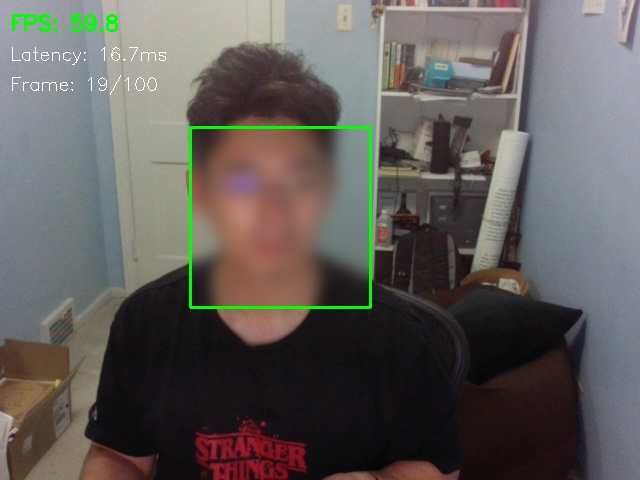

✅ Frame 19 | FPS: 59.8 | Latency: 16.7ms | Detection: 0.0ms | Generator: 2.1ms

📸 Capturing frame 20... (Please allow camera access)


⏹️  Stopped by user

📊 Processed 19 frames
   Final FPS: 59.76
   Final Latency: 16.7ms


In [ ]:
# Continuous Real-Time Processing Loop
# This will keep capturing frames until you interrupt (Ctrl+C or Stop button)

print("🔄 Starting continuous face swapping...")
print("📸 This will continuously capture and process frames")
print("⚠️  Click Stop (or press Ctrl+C) to stop the loop")
print("="*60)

try:
    frame_count = 0
    max_frames = 100  # Maximum frames to process (adjust as needed)

    while frame_count < max_frames:
        # Capture frame from webcam
        print(f"\n📸 Capturing frame {frame_count + 1}... (Please allow camera access)")
        frame = take_photo()

        # Start monitoring
        monitor.start_frame()

        # Update tracker
        bbox = tracker.update(frame)

        # Process frame
        det_time = 0
        gen_time = 0
        result = None

        if bbox is not None:
            result, det_time, gen_time = process_single_frame(
                frame=frame,
                source_embed=source_embed,
                netArc=netArc,
                G=G,
                app=app,
                handler=handler,
                bbox=bbox,
                crop_size=args.crop_size,
                half=False  # Use FP32 for stability
            )

        # Record metrics
        monitor.record_detection_time(det_time)
        monitor.record_generator_time(gen_time)
        total_time = (time.time() - monitor.frame_start_time) * 1000 if monitor.frame_start_time else 0
        monitor.record_processing_time(total_time)
        monitor.end_frame()

        # Display result
        if result is not None and bbox is not None:
            # Expand bbox to show actual swap area (includes forehead and mask expansion)
            x, y, w, h = bbox
            
            # Expand by 20% to better represent actual swap area with mask dilation
            expand_factor = 0.20
            x_expanded = int(x - w * expand_factor / 2)
            y_expanded = int(y - h * expand_factor)  # More expansion upward for forehead
            w_expanded = int(w * (1 + expand_factor))
            h_expanded = int(h * (1 + expand_factor * 1.5))
            
            # Clamp to frame boundaries
            x_expanded = max(0, x_expanded)
            y_expanded = max(0, y_expanded)
            w_expanded = min(result.shape[1] - x_expanded, w_expanded)
            h_expanded = min(result.shape[0] - y_expanded, h_expanded)
            
            # Draw expanded bbox (represents actual swap area)
            cv2.rectangle(result, (x_expanded, y_expanded), 
                         (x_expanded + w_expanded, y_expanded + h_expanded), 
                         (0, 255, 0), 2)
            
            # Add label
            cv2.putText(result, "Swap Area (with forehead)", 
                       (x_expanded, y_expanded - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Add text with stats
            stats = monitor.get_stats()
            cv2.putText(result, f"Face Swapped! FPS: {stats['fps']:.1f}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(result, f"Latency: {stats['avg_latency_ms']:.1f}ms", (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(result, f"Frame: {frame_count + 1}/{max_frames}", (10, 90),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(result, f"Det: {stats['avg_detection_ms']:.1f}ms | Gen: {stats['avg_generator_ms']:.1f}ms", 
                       (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            display_frame = result
        else:
            display_frame = frame.copy()
            status_text = "No face detected - Try better lighting/angle"
            if bbox is not None and result is None:
                status_text = "Face detected but swap failed - Try again"
            cv2.putText(display_frame, status_text, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Save and display
        output_path = '/content/sber-swap/examples/results/realtime_frame.jpg'
        cv2.imwrite(output_path, display_frame)

        # Clear previous output and display new frame
        from IPython.display import Image as IPImage, display, clear_output
        clear_output(wait=True)

        # Display result
        display(IPImage(filename=output_path))

        # Print stats
        stats = monitor.get_stats()
        print(f"✅ Frame {frame_count + 1} | FPS: {stats['fps']:.1f} | "
              f"Latency: {stats['avg_latency_ms']:.1f}ms | "
              f"Detection: {stats['avg_detection_ms']:.1f}ms | "
              f"Generator: {stats['avg_generator_ms']:.1f}ms")

        frame_count += 1

        # Small delay to avoid overwhelming the system
        time.sleep(0.1)

    print(f"\n✅ Processed {frame_count} frames!")
    print("📊 Final Statistics:")
    final_stats = monitor.get_stats()
    print(f"   Average FPS: {final_stats['fps']:.2f}")
    print(f"   Average Latency: {final_stats['avg_latency_ms']:.1f}ms")

except KeyboardInterrupt:
    print("\n\n⏹️  Stopped by user")
    final_stats = monitor.get_stats()
    print(f"\n📊 Processed {frame_count} frames")
    print(f"   Final FPS: {final_stats['fps']:.2f}")
    print(f"   Final Latency: {final_stats['avg_latency_ms']:.1f}ms")

except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()


❌ Error: NotAllowedError: The request is not allowed by the user agent or the platform in the current context, possibly because the user denied permission.


Traceback (most recent call last):
  File "/tmp/ipython-input-2869951515.py", line 4, in <cell line: 0>
    frame = take_photo()
            ^^^^^^^^^^^^
  File "/tmp/ipython-input-2748026091.py", line 39, in take_photo
    data = eval_js(js_code + 'takePhoto()')
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/colab/output/_js.py", line 40, in eval_js
    return _message.read_reply_from_input(request_id, timeout_sec)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_message.py", line 103, in read_reply_from_input
    raise MessageError(reply['error'])
google.colab._message.MessageError: NotAllowedError: The request is not allowed by the user agent or the platform in the current context, possibly because the user denied permission.
